To launch in SuperCloud from a Computed Node


LLsub -i full #for an exclusive node

LLsub -i -s 40 #for node with 40 CPUs

LLsub -i -s 40 -g volta:1 #for node with 40 CPUs and 1 Volta GPU

salloc  --job-name=interactive --qos=high --time=00:60:00 --partition=debug-gpu --gres=gpu:volta:1 --cpus-per-task=40 srun    --pty bash -i

salloc  --job-name=interactive --qos=high --time=02:00:00 --partition=debug-cpu --cpus-per-task=48 srun    --pty bash -i

LLsub -i full

module load anaconda/2023a-pytorch

jupyter lab --no-browser --ip=0.0.0.0 --port=8890

In [2]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from dgd.utils.utils5 import *
from dgd.utils.nnassignments import *
from dgd.utils.verification import *
import pickle
import pandas as pd
import json
import networkx as nx
from tqdm.notebook import tqdm
import time
import subprocess
import multiprocessing
import random
from collections import defaultdict
import socket
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from itertools import cycle
from pathlib import Path
import time
from sklearn.metrics import mean_squared_error, r2_score
import csv
import math
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D          # registers “3d”

In [3]:
#Set seed
global_seed = int.from_bytes(os.urandom(4), "little")
print(f"Generated random seed {global_seed}")
random.seed(global_seed)            
np.random.seed(global_seed)
th.manual_seed(global_seed)    

Generated random seed 2913014640


In [4]:
hostname = socket.gethostname()
print(f"Node: {hostname}")
num_gpus = th.cuda.device_count()
print(f"GPUs: {num_gpus}")
for idx in range(num_gpus):
    props = th.cuda.get_device_properties(idx)
    print(f"GPU {idx}: {props.name} "
          f"({props.total_memory // 1024**2} MB, "
          f"compute capability {props.major}.{props.minor})")
print(f"CPUs in compute node: {multiprocessing.cpu_count()}")

CPUs_alloc = len(os.sched_getaffinity(0)) if hasattr(os, "sched_getaffinity") else int(os.environ.get("SLURM_CPUS_PER_TASK", os.cpu_count() or 1))
print(f"CPUs allocated: {CPUs_alloc}")

Node: login-4
GPUs: 0
CPUs in compute node: 64
CPUs allocated: 64


In [6]:
circuit_name = "0x17"

#File with designs 
file_name = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/20250610_run1_0x17_sampling_bias/optimal_topologies/optimal_topologies.pkl"

# Set up output directory
output_dir = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/20250610_run1_0x17_sampling_bias/optimal_topologies/gate_assignments_using_SA"

Path(output_dir).mkdir(parents=True, exist_ok=True)

In [7]:
with open(file_name, "rb") as f:
    reduced_graphs = pickle.load(f)   
 
print(f"Number of biological circuits: {len(reduced_graphs)}")

Number of biological circuits: 7


In [8]:
#Plot biological circuit designs
for idx, biological_circuit in enumerate(reduced_graphs):
    print(f"Circuit design {idx}")
    #small_topology_plot(biological_circuit)
    plot_circuit_layered(biological_circuit, show_in_notebook=True, notebook_width = 500, save = False) 

Circuit design 0


Circuit design 1


Circuit design 2


Circuit design 3


Circuit design 4


Circuit design 5


Circuit design 6


In [ ]:
#Select graph in graphs
selected_graph = 2  #for 0x17

#selected_graph = 0  #for 0x6D

#It will compute valid permutations if True, otherwise it will try to load a prior computation    
compute_valid_permutations = False

# Total valid permutations to process for trainning data
percentage = 0.05    

In [10]:
topology_networkx = reduced_graphs[selected_graph] 

In [11]:
topology_networkx = reduced_graphs[selected_graph] 

# Define the input nodes
input_nodes = [node for node in topology_networkx.nodes() if topology_networkx.in_degree(node) == 0]
# Generate all permutations of the input nodes
permutations = list(itertools.permutations(input_nodes))
# Create a list to store the permuted graphs
permuted_graphs = []

for perm in permutations:
    new_graph = permute_graph(topology_networkx, perm, input_nodes)

    if calculate_truth_table_v2(new_graph) == calculate_truth_table_v2(topology_networkx):
        idx = len(permuted_graphs)          
        print(f"Permuted graphs {idx}: {perm}")      
        permuted_graphs.append(new_graph)  

Permuted graphs 0: (0, 1, 2)
Permuted graphs 1: (0, 2, 1)
Permuted graphs 2: (1, 0, 2)
Permuted graphs 3: (1, 2, 0)
Permuted graphs 4: (2, 0, 1)
Permuted graphs 5: (2, 1, 0)


Base circuit design


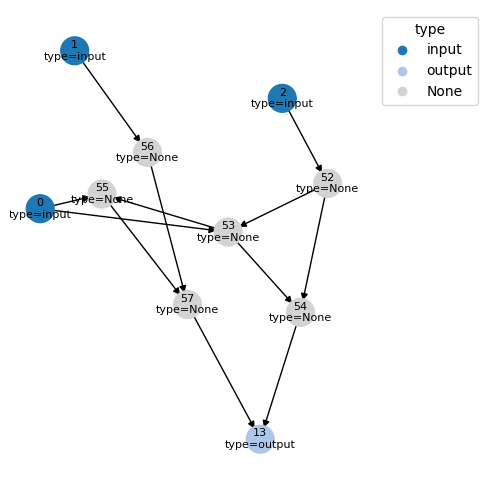

Permutation 0


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [13], 'errors': [], 'warnings': []}
Permutation 1


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [13], 'errors': [], 'warnings': []}
Permutation 2


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [13], 'errors': [], 'warnings': []}
Permutation 3


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [13], 'errors': [], 'warnings': []}
Permutation 4


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [13], 'errors': [], 'warnings': []}
Permutation 5


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [13], 'errors': [], 'warnings': []}


In [12]:
print(f"Base circuit design")
topology_plot_with_attrs(topology_networkx, seed = 1459)

for idx, topology_permutation in enumerate(permuted_graphs):
    print(f"Permutation {idx}")
    #small_topology_plot(topology_permutation) 
    plot_circuit_layered(topology_permutation, show_in_notebook=True, notebook_width = 500, save = False) 
    result = validate_dag(topology_permutation, 1, raise_on_error=True, plot_on_error=True)
    print(result)

In [13]:
permutation_index = 2 #for 0x17
#permutation_index = 0 #for 0x6D

In [14]:
for nodes in topology_networkx.nodes(data = True):
    print(nodes)

(0, {'type': 'input'})
(1, {'type': 'input'})
(2, {'type': 'input'})
(13, {'type': 'output'})
(52, {})
(53, {})
(54, {})
(55, {})
(56, {})
(57, {})


## Import experimental data

In [15]:
input_signals_list_small_molecules, input_names, _ , _ = load_input_data("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/input_data_3_inputs_POSTECH.json")
for row in input_signals_list_small_molecules:
    print(row)

{0: 0.0278, 1: 0.0022, 2: 0.0042}
{0: 0.0278, 1: 0.0022, 2: 2.0082}
{0: 0.0278, 1: 5.0543, 2: 0.0042}
{0: 0.0278, 1: 5.0543, 2: 2.0082}
{0: 3.9239, 1: 0.0022, 2: 0.0042}
{0: 3.9239, 1: 0.0022, 2: 2.0082}
{0: 3.9239, 1: 5.0543, 2: 0.0042}
{0: 3.9239, 1: 5.0543, 2: 2.0082}


In [16]:
input_signals_list_binary = binary_truth_table(len(input_signals_list_small_molecules[0]))
for row in input_signals_list_binary:
    print(row)

{0: 0, 1: 0, 2: 0}
{0: 0, 1: 0, 2: 1}
{0: 0, 1: 1, 2: 0}
{0: 0, 1: 1, 2: 1}
{0: 1, 1: 0, 2: 0}
{0: 1, 1: 0, 2: 1}
{0: 1, 1: 1, 2: 0}
{0: 1, 1: 1, 2: 1}


In [17]:
# Load the part response experimental data
with open("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/response_data_POSTECH.json") as f:
    repressor_data = json.load(f)

# Create DataFrame
postech_v1_hill_function_parameters = pd.DataFrame(repressor_data)

postech_v1_hill_function_parameters

protein_groups = [
    {3, 4, 5},
    {10, 11, 12},
    {14, 15},
    {16, 17, 18, 19},
]

# Load cell growth experimental data
file_path = '/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/growth_data_POSTECH.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract all gate toxicity data
gate_toxicity_data = [item for item in data if item.get("collection") == "gate_toxicity"]

# Convert the list of dictionaries into a DataFrame
gate_toxicity_df = pd.DataFrame(gate_toxicity_data)

# show up to 10 decimal places; adjust as you like
pd.set_option("display.float_format", "{:.10f}".format)

postech_v1_hill_function_parameters


,Repressor,RBS,ymaxa,ymina,Ka,n,Toxicity (RPU)
0,AmeR,F1,3.8350000000,1.0600000000,0.1220000000,1.3060000000,-
1,AmtR,A1,5.0360000000,0.0910000000,0.0220000000,1.3080000000,-
2,BetI,E1,3.0650000000,0.0000000000,0.3630000000,1.8330000000,-
3,BM3R1,B1,0.5430000000,0.0020000000,0.0510000000,2.0420000000,-
4,BM3R1,B2,0.8220000000,0.0000000000,0.2850000000,1.6850000000,-
5,BM3R1,B3,0.7040000000,0.0000000000,0.2610000000,1.7680000000,-
6,HlyIIR,H1,2.4620000000,0.0570000000,0.0000000000,2.5960000000,4.0652500000
7,IcaRA,I1,3.5580000000,0.0000000000,0.1860000000,1.0850000000,0.4709400000
8,LitR,L1,4.2960000000,0.0740000000,0.0000000000,1.6960000000,-
9,LmrA,N1,2.1520000000,0.1830000000,0.0000000000,2.0950000000,-


In [18]:
gate_toxicity_df

,collection,gate_name,input,growth
0,gate_toxicity,F1_AmeR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.936601827, 0.929528441, 0.927586207, 0.9..."
1,gate_toxicity,A1_AmtR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.005567327, 0.987403446, 1.01189251, 1.01..."
2,gate_toxicity,E1_BetI,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.465830721, 1.017868339, 1.023301985, 1.0..."
3,gate_toxicity,B1_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.992753623, 0.971014493, 0.992914654, 0.9..."
4,gate_toxicity,B2_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.978445044, 1.001274554, 1.019855551, 0.9..."
5,gate_toxicity,B3_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.971657754, 0.970707071, 1.015062389, 0.9..."
6,gate_toxicity,H1_HlyIIR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.931501911, 0.945850458, 0.941163746, 0.9..."
7,gate_toxicity,I1_IcaRA,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.019887906, 1.026628502, 1.028642482, 1.0..."
8,gate_toxicity,L1_LitR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.034190532, 1.017241379, 1.034190532, 1.0..."
9,gate_toxicity,N1_LmrA,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.948325359, 0.884901648, 0.884237108, 0.8..."


### Adquire data from objective objective function 

#### Load possible permutations without repeating repressor

In [19]:
gate_count, info = energy_score(topology_networkx, check_implicit_OR_existence_v3)
print(f"Gate count: {gate_count}")
print(f"Info: {info}")

Gate count: 6
Info: {'num_nodes': 10, 'num_inputs': 3, 'num_outputs': 1, 'max_removal': 0, 'best_pattern_key': None}


In [20]:
DATA_DIR = Path("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data")  
                 
file_path = DATA_DIR / "gate_permutations" / f"valid_permutations_{gate_count}_gates.h5"

list_of_gates_indices = list(range(len(postech_v1_hill_function_parameters)))
if compute_valid_permutations:
    print("Computing valid gate permutations")
    valid_permutations = generate_and_filter_permutations_v2(list_of_gates_indices, gate_count, protein_groups, max_per_group=1)
    save_valid_permutations(valid_permutations, file_path)
else:
    if file_path.is_file():           
        print(f"Found: {file_path}")
        print("Loading valid gate permutations")
        valid_permutations = load_valid_permutations(file_path)
        
    else:
        print(f"Missing: {file_path}")
        print("Computing valid gate permutations because file does not exist")   
        valid_permutations = generate_and_filter_permutations_v2(list_of_gates_indices, gate_count, protein_groups, max_per_group=1)
        save_valid_permutations(valid_permutations, file_path)   
        
print(f"Total valid permutations: {len(valid_permutations)}")
print("Example permutation:", valid_permutations[0] if valid_permutations else "No permutations found")

Found: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/gate_permutations/valid_permutations_6_gates.h5
Loading valid gate permutations
Total valid permutations: 8739360
Example permutation: (0, 1, 2, 3, 6, 7)


#### Set sample size

In [21]:
num_samples = round(len(valid_permutations)*percentage) 
subsample_size = num_samples

#### Adquire trainning data (multiple cores)

In [22]:
Gi = permuted_graphs[permutation_index]
list(Gi.nodes(data = True))

[(1, {'type': 'input'}),
 (0, {'type': 'input'}),
 (2, {'type': 'input'}),
 (13, {'type': 'output'}),
 (52, {}),
 (53, {}),
 (54, {}),
 (55, {}),
 (56, {}),
 (57, {})]

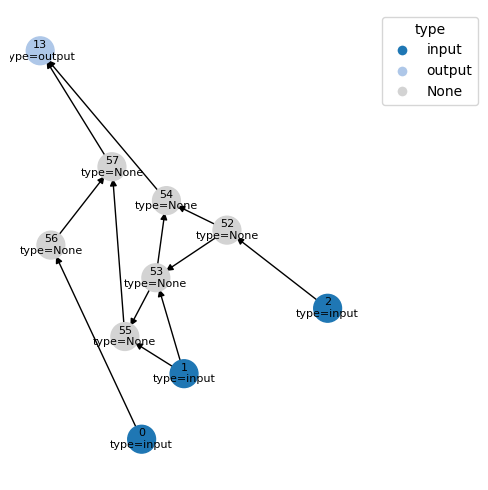

In [23]:
topology_plot_with_attrs(Gi)

In [24]:
nodelist = sorted(Gi.nodes())
list(sorted(Gi.nodes(data = True)))

[(0, {'type': 'input'}),
 (1, {'type': 'input'}),
 (2, {'type': 'input'}),
 (13, {'type': 'output'}),
 (52, {}),
 (53, {}),
 (54, {}),
 (55, {}),
 (56, {}),
 (57, {})]

In [25]:
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()
adj_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

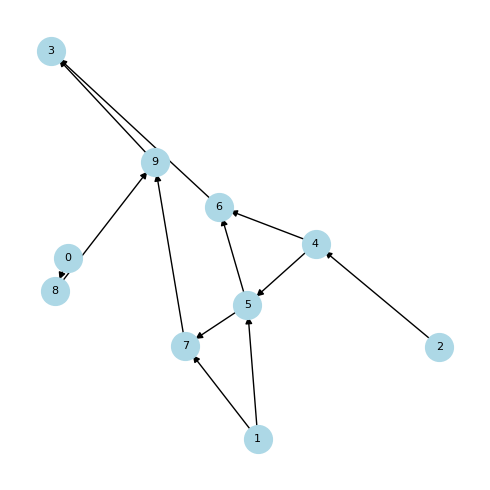

In [26]:
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)

# Remove disconnected nodes (nodes with neither incoming nor outgoing edges)
disconnected_nodes = [node for node in G.nodes() if G.in_degree(node) == 0 and G.out_degree(node) == 0]
G.remove_nodes_from(disconnected_nodes)
topology_plot_with_attrs(G)

In [27]:
input_nodes = [node for node in G.nodes() if G.in_degree(node) == 0]
output_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

# Filter nodes that are neither inputs nor outputs
non_io_nodes = [node for node in G.nodes() if node not in input_nodes and node not in output_nodes]
non_io_nodes

[4, 5, 6, 7, 8, 9]

In [28]:
Gi = permuted_graphs[permutation_index]
nodelist = sorted(Gi.nodes())
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()

SA

In [31]:
import random

def getRandomGateFromUnassignedGroup(current_solution, gate_library):
    # Define the groups of gates
    group_AmeR = [0]
    group_AmtR = [1]
    group_BetI = [2]
    group_BM3R1 = [3, 4, 5]
    group_HlyIIR = [6]
    group_IcaRA = [7]
    group_LitR = [8]
    group_LmrA = [9]
    group_PhlF = [10, 11, 12]
    group_PsrA = [13]
    group_QacR = [14, 15]
    group_SrpR = [16, 17, 18, 19]
    
    # Step 1: Create a list of all groups for easier processing
    all_groups = [
        group_AmeR, group_AmtR, group_BetI, group_BM3R1, 
        group_HlyIIR, group_IcaRA, group_LitR, group_LmrA,
        group_PhlF, group_PsrA, group_QacR, group_SrpR
    ]
    
    # Step 2: Rule out groups that have integers in current solution
    available_groups = []
    for group in all_groups:
        # Check if any number from this group is in current_solution
        group_is_available = True
        for gate in group:
            if gate in current_solution:
                group_is_available = False
                break
        # If no number from this group is in current_solution, add it to available_groups
        if group_is_available:
            available_groups.append(group)
    
    # Step 3: Get a random group from available groups
    if not available_groups:  # Check if there are any available groups
        return None  # Return None if no groups are available
    random_group = random.choice(available_groups)
    
    # Step 4: Get a random integer from the selected group
    random_gate = random.choice(random_group)
    
    # Step 5: Return the randomly selected gate
    return random_gate


def getRandomGateFromUnassignedGroup_with_max_inputs_restriction(current_solution, gate_library, G, gate_max_incoming_signals_df):
    # Define the groups of gates
    group_AmeR = [0]
    group_AmtR = [1]
    group_BetI = [2]
    group_BM3R1 = [3, 4, 5]
    group_HlyIIR = [6]
    group_IcaRA = [7]
    group_LitR = [8]
    group_LmrA = [9]
    group_PhlF = [10, 11, 12]
    group_PsrA = [13]
    group_QacR = [14, 15]
    group_SrpR = [16, 17, 18, 19]
    
    # Step 0: Remove gates that cannot be assigned based on incoming signals
    # Use the validate_max_incoming_signals function
    all_groups = [
        group_AmeR, group_AmtR, group_BetI, group_BM3R1, 
        group_HlyIIR, group_IcaRA, group_LitR, group_LmrA,
        group_PhlF, group_PsrA, group_QacR, group_SrpR
    ]
    
    filtered_groups = []
    for group in all_groups:
        filtered_group = []
        for gate in group:
            # Check if the gate can be assigned using validate_max_incoming_signals
            can_assign = validate_max_incoming_signals(
                graph=G,
                dataframe=gate_library,
                repressor_index=gate,
                gate_max_incoming_signals_df=gate_max_incoming_signals_df
            )
            if can_assign:
                filtered_group.append(gate)
        if filtered_group:
            filtered_groups.append(filtered_group)
    
    # If no gates are left after filtering, return None
    if not filtered_groups:
        return None
    
    # Step 1: Use the filtered groups for further processing
    all_groups = filtered_groups

    # Step 2: Rule out groups that have gates already in current_solution
    available_groups = []
    for group in all_groups:
        # Check if any gate from this group is in current_solution
        group_is_available = True
        for gate in group:
            if gate in current_solution:
                group_is_available = False
                break
        # If no gate from this group is in current_solution, add it to available_groups
        if group_is_available:
            available_groups.append(group)
    
    # Step 3: Get a random group from available groups
    if not available_groups:  # Check if there are any available groups
        return None  # Return None if no groups are available
    random_group = random.choice(available_groups)
    
    # Step 4: Get a random gate from the selected group
    random_gate = random.choice(random_group)
    
    # Step 5: Return the randomly selected gate
    return random_gate



def simulated_annealing_cello2(
    adj_matrix, initial_solution, MAXTEMP, MINTEMP, steps, T0_steps,
    input_signals_list_small_molecules, input_signals_list_binary,
    gate_library, gate_toxicity_df, D_GROWTH_THRESHOLD=0.75, print_statements = False, plot = False
):
    """
    This function implements the simulated annealing algorithm in Cello 2.

    Parameters:
    - df: DataFrame containing gate data.
    - adj_matrix: adjacency matrix of the circuit.
    - initial_solution: initial assignment of gates to nodes (list of indices in df).
    - MAXTEMP, MINTEMP: initial and final temperatures.
    - steps: number of steps before reaching Tmin.
    - T0_steps: number of steps at Tmin.
    - input_signals_list_small_molecules: list of input signals for simulation.
    - input_signals_list_binary: list of expected binary outputs.
    - gate_toxicity_df: DataFrame containing toxicity data.
    - D_GROWTH_THRESHOLD: growth threshold for toxicity evaluation.
    """

    # Initialize current solution
    G_initial = assign_representations_with_io_nodes_3(adj_matrix, gate_library, initial_solution)    
    expected_logic_initial = simulate_signal_propagation_binary(G_initial, input_signals_list_binary)
    actual_logic_initial = simulate_signal_propagation(G_initial, input_signals_list_small_molecules)
    circuit_score_initial = calculate_circuit_score(expected_logic_initial, actual_logic_initial)
    toxicity_score_initial, detailed_results_initial = calculate_toxicity_score(input_signals_list_small_molecules, G_initial, gate_toxicity_df)
    
    optimal_score = circuit_score_initial
    optimal_toxicty = toxicity_score_initial
    optimal_solution = initial_solution.copy()
    
    # Initialize current solution
    current_solution = initial_solution.copy()
    
    # Temperature parameters
    LOGMAX = math.log10(MAXTEMP)
    LOGMIN = math.log10(MINTEMP)
    LOGINC = (LOGMAX - LOGMIN) / steps

    total_steps = steps + T0_steps

  
    # Lists to track scores for visualization
    iteration_numbers = []
    optimal_scores = []


    for j in tqdm(range(total_steps), desc="Optimizing", leave=True):
        logTemperature = LOGMAX - j * LOGINC 
        temperature = math.pow(10, logTemperature)
        
        if j >= steps:
            temperature = 0.0
        
        
        print("temp",  temperature) if print_statements else None       
        print("log(temp)", logTemperature) if print_statements else None

        G_current = assign_representations_with_io_nodes_3(adj_matrix, gate_library, current_solution)
        expected_logic_current = simulate_signal_propagation_binary(G_current, input_signals_list_binary)
        actual_logic_current = simulate_signal_propagation(G_current, input_signals_list_small_molecules)
        circuit_score_current = calculate_circuit_score(expected_logic_current, actual_logic_current)
        toxicity_score_current, detailed_results = calculate_toxicity_score(input_signals_list_small_molecules, G_current, gate_toxicity_df)
        
        #rejectImmediately = False;
        #tandemSwap = False; not used    
        
        # Decide whether to perform tandem swap or gate swap
        r = random.random()
        
        #if (r < thresh):
        #    tandemSwap = True;
        
        print("Current solution: ", current_solution) if print_statements else None    
        
           
        # If gate <-> library swap
        gateA = getRandomGateFromUnassignedGroup(current_solution, gate_library);
        #gateA_types = getGateTypeinLibrary(gateA)
        if (gateA == None):
            gateA = random.choice(current_solution)
        
        while True:
            gateB = random.choice(current_solution);
            #if (gateA != gateB and gateA_type == gateBtype):
            if (gateA != gateB):
                break     
                
        #if not tandem swap
        #if !tandemSwap: Not used
        roadblock_flags_before = is_roadblocking(G_current)
        numBlockedBefore = len(roadblock_flags_before[1])

        if gateA in current_solution and gateB in current_solution:
            new_solution = swap_within_circuit(current_solution, gateA, gateB)
        else:
            circuit_gate = gateB
            library_gate = gateA
            new_solution = swap_with_library(current_solution, circuit_gate, library_gate)

        G_new = assign_representations_with_io_nodes_3(adj_matrix, gate_library, new_solution)
        roadblock_flags_after = is_roadblocking(G_new)
        numBlockedAfter = len(roadblock_flags_after[1])

        if (numBlockedAfter > numBlockedBefore):
            
            # roadblocking is worse, so reject
            iteration_numbers.append(j)
            optimal_scores.append(optimal_score)
            continue #go to the next iteration
          
        # evaluate
        actual_logic_new = simulate_signal_propagation(G_new, input_signals_list_small_molecules)
        expected_logic_new = simulate_signal_propagation_binary(G_new, input_signals_list_binary)
        circuit_score_new = calculate_circuit_score(expected_logic_new, actual_logic_new)
        toxicity_score_new, detailed_results_new = calculate_toxicity_score(input_signals_list_small_molecules, G_new, gate_toxicity_df)

        if (toxicity_score_current < D_GROWTH_THRESHOLD):
            if (toxicity_score_new > toxicity_score_current):
                print("Accept immediately -- already below mimimum growth threshold, and this swap helps.") if print_statements else None
                
                current_solution = new_solution.copy()
                
                if circuit_score_new > optimal_score and (toxicity_score_new >= D_GROWTH_THRESHOLD):
                    optimal_score = circuit_score_new
                    optimal_toxicty = toxicity_score_new
                    optimal_solution = new_solution.copy()
                
                iteration_numbers.append(j)
                optimal_scores.append(optimal_score)
                
                continue
            else:
                # undo
                #rejectImmediately = True
                print("Reject immediately -- already below mimimum growth threshold, and this swap does not help.") if print_statements else None
                
                iteration_numbers.append(j)
                optimal_scores.append(optimal_score)
                
                continue

        elif (toxicity_score_new < D_GROWTH_THRESHOLD):
        # // undo
            #rejectImmediately = True;
            print("Reject immediately -- below minimum growth threshold.") if print_statements else None
            
            iteration_numbers.append(j)
            optimal_scores.append(optimal_score)
            
            continue

        # Not used    
        #undo
        #if (rejectImmediately):
        #    #Undo solution
        #    pass
        
        #acept or reject 
        before = circuit_score_current
        after = circuit_score_new
        #probability = math.exp((after - before) / temperature)
        #probability = safe_exp((after - before) / temperature)
        
        if temperature == 0:
            # Only accept improvements when temperature is 0
            probability = 1.0 if after > before else 0.0
        else:
            probability = safe_exp((after - before) / temperature)          
        
        ep = random.random()  # Returns a float between 0.0 and 1.0

        if (ep < probability):
            #accept
            print("Accept") if print_statements else None
            current_solution = new_solution.copy()
            
            if circuit_score_new > optimal_score and (toxicity_score_new >= D_GROWTH_THRESHOLD):
                optimal_score = circuit_score_new
                optimal_toxicty = toxicity_score_new
                optimal_solution = new_solution.copy()
            
        else:
            #reject swap
            pass
        


        iteration_numbers.append(j)
        optimal_scores.append(optimal_score)

    if (plot):    
        # Plotting iterations vs highest score
        plt.figure(figsize=(8, 4))
        plt.plot(iteration_numbers, optimal_scores, marker='o', markersize=3, linestyle='--', color='b')
        plt.title('Iterations vs Highest Score')
        plt.xlabel('Iteration')
        plt.ylabel('Circuit Score')
        plt.show()

    # Optionally, draw the final network
    #draw_network_with_colors_and_labels_from_G(G)

    return optimal_score, optimal_toxicty, optimal_solution

def safe_exp(x):
    try:
        return math.exp(x)
    except OverflowError:
        if x > 0:
            return float('inf')
        return 0

Cello 2 parameters

Optimizing:   0%|          | 0/700 [00:00<?, ?it/s]

Optimizing:   0%|          | 0/700 [00:00<?, ?it/s]

Optimizing:   0%|          | 0/700 [00:00<?, ?it/s]

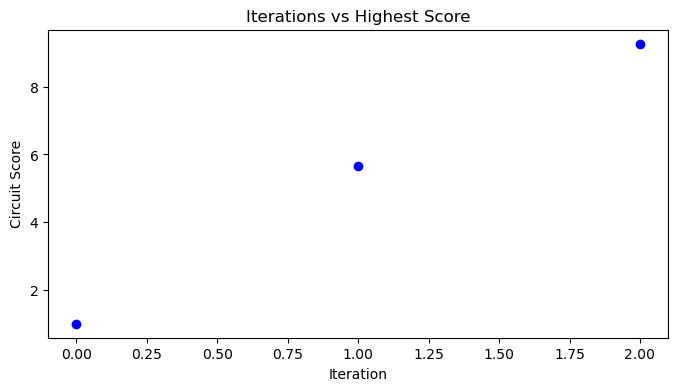

In [38]:
saved_run_results = []
run_number = []
num_runs = 3
top_circuit_score = 0
top_toxicity_score = 0
top_solution = 0

for run in range(0, num_runs):
    initial_solution = random_part_selection(postech_v1_hill_function_parameters, gate_count)
    MAXTEMP = 100.0
    MINTEMP = 0.001
    steps = 600
    T0_steps = 100

    optimized_score, optimal_toxicty, optimal_solution = simulated_annealing_cello2(
        adj_matrix, initial_solution, MAXTEMP, MINTEMP, steps, T0_steps,
        input_signals_list_small_molecules, input_signals_list_binary,
        postech_v1_hill_function_parameters, gate_toxicity_df, D_GROWTH_THRESHOLD=0.75)

    saved_run_results.append(optimized_score)
    run_number.append(run)
    
    if optimized_score > top_circuit_score:
        top_circuit_score = optimized_score
        top_toxicity_score = optimal_toxicty
        top_solution = optimal_solution

# Plotting iterations vs highest score
plt.figure(figsize=(8, 4))
plt.scatter(run_number, saved_run_results, color='b')
plt.title('Iterations vs Highest Score')
plt.xlabel('Iteration')
plt.ylabel('Circuit Score')
plt.show()

Synthetic gene circuit


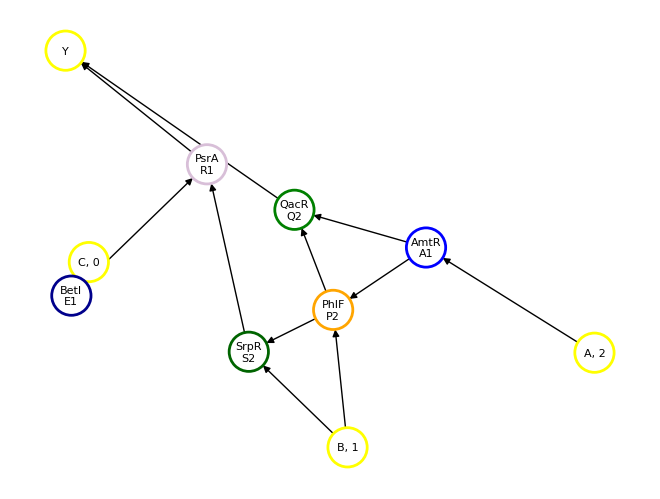

13.708035201818916
0.7611735686841834


In [33]:
G = assign_representations_with_io_nodes_3(adj_matrix, postech_v1_hill_function_parameters, top_solution) 
print("Synthetic gene circuit")
draw_network_with_colors_and_labels_from_G(G)

expected_logic_current = simulate_signal_propagation_binary(G, input_signals_list_binary)
actual_logic_current = simulate_signal_propagation(G, input_signals_list_small_molecules)
circuit_score_current = calculate_circuit_score(expected_logic_current, actual_logic_current)
toxicity_score_current, detailed_results = calculate_toxicity_score(input_signals_list_small_molecules, G, gate_toxicity_df)
print(circuit_score_current)
print(toxicity_score_current)

Cello 2 parameters and more, including random seed


In [36]:
total = round(len(valid_permutations)*percentage)  

In [35]:
import os, json, math, random, itertools
import numpy as np
import pandas as pd
from datetime import datetime

MINTEMP = 1e-3  
MAXTEMPS = [1, 1e1, 1e2, 1e3]  
steps = round(total*(1-0.02))
T0_steps = round(total*(0.02))
N_SEEDS = 3
N_INITIALS = 1

results_csv = "sa_sweep_results.csv"
solutions_json = "sa_sweep_solutions.json"   # to store full optimal solutions

# ----------------------------------------------------
# Draw 3 random seeds (independent of initial states)
# ----------------------------------------------------
seeds = [int.from_bytes(os.urandom(4), "little") for _ in range(N_SEEDS)]

# ----------------------------------------------------
# Precompute 3 random initial solutions ONCE so that
# all seeds test the SAME 3 initial states.
# Use a dedicated RNG state to avoid coupling with `seeds`.
# ----------------------------------------------------
tmp_seed_for_initials = int.from_bytes(os.urandom(4), "little")
random.seed(tmp_seed_for_initials)
np.random.seed(tmp_seed_for_initials)

initial_solutions = []
for i in range(N_INITIALS):
    init_sol = random_part_selection(postech_v1_hill_function_parameters, gate_count)
    initial_solutions.append(init_sol)

# -------------------------------------------------------
# Run sweep: for each seed × initial_solution × MAXTEMP
# -------------------------------------------------------
rows = []
solutions_store = []  # list of dicts (seed, init_id, maxtemp, solution list)

top_circuit_score = -float("inf")
top_toxicity_score = None
top_solution = None
top_meta = None

run_counter = 0

for seed in seeds:
    # set PRNGs for this run (affects SA stochasticity, not the initial_solutions)
    random.seed(seed)
    np.random.seed(seed)

    for init_id, initial_solution in enumerate(initial_solutions):
        for maxt in MAXTEMPS:
            run_counter += 1

            optimized_score, optimal_toxicty, optimal_solution = simulated_annealing_cello2(
                adj_matrix,
                initial_solution,
                maxt, MINTEMP,
                steps, T0_steps,
                input_signals_list_small_molecules,
                input_signals_list_binary,
                postech_v1_hill_function_parameters,
                gate_toxicity_df,
                D_GROWTH_THRESHOLD=0.75,
                plot=False  # keep off for batch
            )

            # Save a compact row for CSV
            rows.append({
                "run_id": run_counter,
                "seed": seed,
                "initial_id": init_id,         # 0..2
                "MAXTEMP": maxt,
                "MINTEMP": MINTEMP,
                "steps": steps,
                "T0_steps": T0_steps,
                "optimized_score": optimized_score,
                "optimal_toxicity": optimal_toxicty,
            })

            # Save the full optimal solution separately (JSON)
            solutions_store.append({
                "run_id": run_counter,
                "seed": seed,
                "initial_id": init_id,
                "MAXTEMP": maxt,
                "MINTEMP": MINTEMP,
                "optimal_solution": optimal_solution,  # list-like
            })

            # Track global best
            if optimized_score > top_circuit_score:
                top_circuit_score = optimized_score
                top_toxicity_score = optimal_toxicty
                top_solution = optimal_solution
                top_meta = {
                    "seed": seed,
                    "initial_id": init_id,
                    "MAXTEMP": maxt,
                    "MINTEMP": MINTEMP,
                }

# --------------------------------
# Save results
# --------------------------------
df = pd.DataFrame(rows)
df["timestamp"] = datetime.now().isoformat(timespec="seconds")
df.to_csv(results_csv, index=False)

with open(solutions_json, "w") as f:
    json.dump({
        "timestamp": datetime.now().isoformat(timespec="seconds"),
        "solutions": solutions_store,
        "best_overall": {
            "optimized_score": top_circuit_score,
            "optimal_toxicity": top_toxicity_score,
            "meta": top_meta,
            "optimal_solution": top_solution,
        }
    }, f, indent=2)

print(f"Saved run table to: {results_csv}")
print(f"Saved solutions to: {solutions_json}")
print("Best overall:")
print("  score:", top_circuit_score)
print("  tox:", top_toxicity_score)
print("  meta:", top_meta)


Optimizing:   0%|          | 0/436968 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
G = assign_representations_with_io_nodes_3(adj_matrix, postech_v1_hill_function_parameters, top_solution) 
print("Synthetic gene circuit")
draw_network_with_colors_and_labels_from_G(G)

expected_logic_current = simulate_signal_propagation_binary(G, input_signals_list_binary)
actual_logic_current = simulate_signal_propagation(G, input_signals_list_small_molecules)
circuit_score_current = calculate_circuit_score(expected_logic_current, actual_logic_current)
toxicity_score_current, detailed_results = calculate_toxicity_score(input_signals_list_small_molecules, G, gate_toxicity_df)
print(circuit_score_current)
print(toxicity_score_current)

In [ ]:
 
random_part_selection(postech_v1_hill_function_parameters, gate_count)